## How have religious beliefs changed in London between 2001 and 2011?

In [ ]:
'''
Grading criteria:
1) identify the region and domain category that their data sets are about
The region I live in is London and the topic assigned was Religion.

2) state a research question that related to the domain category and region they identified
How have religous beliefs changed in London between 2001 and 2011?

3) provide links to at least two working links to publicly available data sets (including links to CSV or Excel files)

- The main two files used in this analysis are provided by the Infuse portal:
- 2011 census data: http://infuse.ukdataservice.ac.uk/infusewiz.aspx?cookie=openaccess
- use of this data also has to cite the Office for National Statistics ; National Records of Scotland ; Northern Ireland Statistics and Research Agency (2017): 2011 Census aggregate data. UK Data Service (Edition: February 2017). DOI: http://dx.doi.org/10.5257/census/aggregate-2011-2
- this information is licensed under the terms of the Open Government Licence [http://www.nationalarchives.gov.uk/doc/open-government-licence/version/2].

4) upload an image that addresses the stated question
5) write a short (1-2 paragraph) justification of how the visualization addresses the question
- describe your design choices for your visual in regards to Cairo's principle of truthfulness
- describe your design choices for your visual in regards to Cairo's principle of beauty.
- describe your design choices for your visual in regards to Cairo's principle of functionality
- describe your design choices for your visual in regards to Cairo's principle of insightfulness
'''

In [371]:
%matplotlib notebook

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colorbar as clb
from matplotlib.colors import Normalize
from matplotlib.ticker import FormatStrFormatter
from matplotlib.collections import PatchCollection
from mpl_toolkits.basemap import Basemap
from itertools import chain
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
from shapely.prepared import prep
from descartes import PolygonPatch
from pysal.esda.mapclassify import Natural_Breaks as nb

## Read in religion data

In [355]:
# Read in census response to religion question by ward (low unit of geography)
# For 2001 census:
religion_2001 = pd.read_csv('data/2001_census_religion_ward_level/Data_RELIEW_UNIT.csv', 
                            usecols=([1,5,6,7,8,9,10,11,12,13,14]), skiprows = 2, 
                                names=['output_area_2001', 'tot_pop_surveyed_2001',
                                      'pop_christian_2001', 'pop_buddhist_2001','pop_hindu_2001','pop_jewish_2001',
                                       'pop_muslim_2001','pop_sikh_2001','pop_other_religion_2001',
                                       'pop_no_religion_2001','pop_religion_not_stated_2001'])

# Check that the surveyed population equals the sum of the other columns
religion_2001['check_sum'] = sum([religion_2001.pop_christian_2001, religion_2001.pop_buddhist_2001, 
                                  religion_2001.pop_hindu_2001, religion_2001.pop_jewish_2001, religion_2001.pop_muslim_2001, 
                                  religion_2001.pop_sikh_2001, religion_2001.pop_other_religion_2001,
                                  religion_2001.pop_no_religion_2001, religion_2001.pop_religion_not_stated_2001])

religion_2001.head()

,output_area_2001,tot_pop_surveyed_2001,pop_christian_2001,pop_buddhist_2001,pop_hindu_2001,pop_jewish_2001,pop_muslim_2001,pop_sikh_2001,pop_other_religion_2001,pop_no_religion_2001,pop_religion_not_stated_2001,check_sum
0,00AAFA0001,215,108,0,9,7,0,0,0,64,27,215
1,00AAFA0002,98,51,0,0,5,3,0,0,30,9,98
2,00AAFA0003,214,99,0,8,6,5,0,0,64,32,214
3,00AAFA0004,277,151,3,3,14,0,0,0,80,26,277
4,00AAFA0005,231,138,5,13,11,0,0,0,46,18,231


In [356]:
# For 2011 census:
religion_2011 = pd.read_csv('data/2011_census_religion_ward_level/Data_RELIG_UNIT.csv', 
                            usecols=([1,5,6,7,8,9,10,11,12,13,14]), skiprows = 2,
                                names=['output_area_2011', 'tot_pop_surveyed_2011',
                                      'pop_christian_2011', 'pop_buddhist_2011','pop_hindu_2011','pop_jewish_2011',
                                       'pop_muslim_2011','pop_sikh_2011','pop_other_religion_2011',
                                       'pop_no_religion_2011','pop_religion_not_stated_2011'])

religion_2011.head()

,output_area_2011,tot_pop_surveyed_2011,pop_christian_2011,pop_buddhist_2011,pop_hindu_2011,pop_jewish_2011,pop_muslim_2011,pop_sikh_2011,pop_other_religion_2011,pop_no_religion_2011,pop_religion_not_stated_2011
0,E00000001,194.0,82.0,1.0,1.0,3.0,0.0,0.0,0.0,87.0,20.0
1,E00000003,250.0,104.0,1.0,10.0,18.0,5.0,0.0,0.0,96.0,16.0
2,E00000005,367.0,167.0,6.0,6.0,10.0,0.0,0.0,0.0,144.0,34.0
3,E00000007,123.0,56.0,2.0,5.0,2.0,6.0,0.0,1.0,39.0,12.0
4,E00000010,102.0,33.0,1.0,0.0,2.0,5.0,1.0,1.0,42.0,17.0


## Read in lookup from 2001 to 2011 output areas

In [357]:
'''
- U - No Change - S - Split
- M - Merge
- X - Any other changes that are not covered by the above categories
'''

OA_lookup_2001_2011 = pd.read_csv('data/2001_2011_OA_lookup/OA01_OA11_EW_LU.csv', 
                            usecols=([1,2,3]), skiprows = 1,
                                names=['output_area_2001', 'output_area_2011','change_code_2001_2011'])

OA_lookup_2001_2011.head()

,output_area_2001,output_area_2011,change_code_2001_2011
0,00AAFA0001,E00000001,U
1,00AAFA0002,E00166756,M
2,00AAFA0003,E00000003,U
3,00AAFA0004,E00166758,M
4,00AAFA0005,E00000005,U


In [5]:
OA_lookup_2001_2011.groupby('change_code_2001_2011')['output_area_2001'].nunique()

change_code_2001_2011
M      1115
S      3239
U    170865
X       215
Name: output_area_2001, dtype: int64

In [6]:
# Merge only unchanged output areas for purpose of this comparison

OA_lookup_2001_2011 = OA_lookup_2001_2011[OA_lookup_2001_2011['change_code_2001_2011'] == 'U']
religion_2001_with_2011_OAs = pd.merge(religion_2001, OA_lookup_2001_2011, how='inner', on=['output_area_2001'])

religion_2001_with_2011_OAs.head()

,output_area_2001,tot_pop_surveyed_2001,pop_christian_2001,pop_buddhist_2001,pop_hindu_2001,pop_jewish_2001,pop_muslim_2001,pop_sikh_2001,pop_other_religion_2001,pop_no_religion_2001,pop_religion_not_stated_2001,check_sum,output_area_2011,change_code_2001_2011
0,00AAFA0001,215,108,0,9,7,0,0,0,64,27,215,E00000001,U
1,00AAFA0003,214,99,0,8,6,5,0,0,64,32,214,E00000003,U
2,00AAFA0005,231,138,5,13,11,0,0,0,46,18,231,E00000005,U
3,00AAFA0007,170,106,0,3,4,3,0,0,51,3,170,E00000007,U
4,00AAFQ0001,130,82,0,0,0,3,0,3,27,15,130,E00000010,U


## Merge census data file together

In [7]:
combined_census_data = pd.merge(religion_2001_with_2011_OAs, religion_2011, how='inner', on=['output_area_2011'])
combined_census_data.head()

,output_area_2001,tot_pop_surveyed_2001,pop_christian_2001,pop_buddhist_2001,pop_hindu_2001,pop_jewish_2001,pop_muslim_2001,pop_sikh_2001,pop_other_religion_2001,pop_no_religion_2001,...,tot_pop_surveyed_2011,pop_christian_2011,pop_buddhist_2011,pop_hindu_2011,pop_jewish_2011,pop_muslim_2011,pop_sikh_2011,pop_other_religion_2011,pop_no_religion_2011,pop_religion_not_stated_2011
0,00AAFA0001,215,108,0,9,7,0,0,0,64,...,194.0,82.0,1.0,1.0,3.0,0.0,0.0,0.0,87.0,20.0
1,00AAFA0003,214,99,0,8,6,5,0,0,64,...,250.0,104.0,1.0,10.0,18.0,5.0,0.0,0.0,96.0,16.0
2,00AAFA0005,231,138,5,13,11,0,0,0,46,...,367.0,167.0,6.0,6.0,10.0,0.0,0.0,0.0,144.0,34.0
3,00AAFA0007,170,106,0,3,4,3,0,0,51,...,123.0,56.0,2.0,5.0,2.0,6.0,0.0,1.0,39.0,12.0
4,00AAFQ0001,130,82,0,0,0,3,0,3,27,...,102.0,33.0,1.0,0.0,2.0,5.0,1.0,1.0,42.0,17.0


## Merge on higher level area lookups

In [8]:
area_lookups_2011 = pd.read_csv('data/area_lookups_2011/All areas lookup.csv', 
                            usecols=([13,14,17,18,20,21,23,24,33,34,44]), skiprows = 1, encoding = "ISO-8859-1",
                                names=['country_code','country_name','region_code','region_name',
                                       'county_code','county_name','local_authority_code','local_authority_name',
                                       'ward_code','ward_name','output_area_2011'])
print(area_lookups_2011.shape)

(232422, 11)


/Users/nigelnicholson/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (17,18,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [179]:
area_lookups_2011.head()

,country_code,country_name,region_code,region_name,county_code,county_name,local_authority_code,local_authority_name,ward_code,ward_name,output_area_2011
0,E92000001,England,E12000001,North East,E11000004,Tyne and Wear,E08000020,Gateshead,E05001072,Crawcrook and Greenside,E00041840
1,E92000001,England,E12000001,North East,E11000004,Tyne and Wear,E08000020,Gateshead,E05001082,"Ryton, Crookhill and Stella",E00041814
2,E92000001,England,E12000001,North East,E11000004,Tyne and Wear,E08000020,Gateshead,E05001082,"Ryton, Crookhill and Stella",E00041830
3,E92000001,England,E12000001,North East,E11000004,Tyne and Wear,E08000020,Gateshead,E05001082,"Ryton, Crookhill and Stella",E00041834
4,E92000001,England,E12000001,North East,E11000004,Tyne and Wear,E08000020,Gateshead,E05001082,"Ryton, Crookhill and Stella",E00041835


In [10]:
# Create master religion dataset with data for both censuses and area lookups for 2011
mrd = pd.merge(combined_census_data, area_lookups_2011, how='inner', on=['output_area_2011'])
print(mrd.shape)

(170865, 34)


In [11]:
mrd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 170865 entries, 0 to 170864
Data columns (total 34 columns):
output_area_2001                170865 non-null object
tot_pop_surveyed_2001           170865 non-null int64
pop_christian_2001              170865 non-null int64
pop_buddhist_2001               170865 non-null int64
pop_hindu_2001                  170865 non-null int64
pop_jewish_2001                 170865 non-null int64
pop_muslim_2001                 170865 non-null int64
pop_sikh_2001                   170865 non-null int64
pop_other_religion_2001         170865 non-null int64
pop_no_religion_2001            170865 non-null int64
pop_religion_not_stated_2001    170865 non-null int64
check_sum                       170865 non-null int64
output_area_2011                170865 non-null object
change_code_2001_2011           170865 non-null object
tot_pop_surveyed_2011           170865 non-null float64
pop_christian_2011              170865 non-null float64
pop_buddhist_2011 

## Summarise religious change between censuses at different levels of census geography

In [291]:
def mega_sum(summary_vars):
    
    temp_summary = mrd[['tot_pop_surveyed_2001','pop_christian_2001','pop_buddhist_2001','pop_hindu_2001',
                      'pop_jewish_2001','pop_muslim_2001','pop_sikh_2001','pop_other_religion_2001',
                      'pop_no_religion_2001','pop_religion_not_stated_2001','tot_pop_surveyed_2011',
                      'pop_christian_2011','pop_buddhist_2011','pop_hindu_2011','pop_jewish_2011',
                      'pop_muslim_2011','pop_sikh_2011','pop_other_religion_2011','pop_no_religion_2011',
                      'pop_religion_not_stated_2011']].groupby(summary_vars).sum().reset_index()
    
    # Calculate percentages of population by religion for 2001 census:

    temp_summary['perc_christian_2001'] = temp_summary['pop_christian_2001'] / temp_summary['tot_pop_surveyed_2001']
    temp_summary['perc_no_religion_2001'] = temp_summary['pop_no_religion_2001'] / temp_summary['tot_pop_surveyed_2001']
    temp_summary['perc_muslim_2001'] = temp_summary['pop_muslim_2001'] / temp_summary['tot_pop_surveyed_2001']
    temp_summary['perc_religion_not_stated_2001'] = temp_summary['pop_religion_not_stated_2001'] / temp_summary['tot_pop_surveyed_2001']
    temp_summary['perc_hindu_2001'] = temp_summary['pop_hindu_2001'] / temp_summary['tot_pop_surveyed_2001']
    temp_summary['perc_jewish_2001'] = temp_summary['pop_jewish_2001'] / temp_summary['tot_pop_surveyed_2001']
    temp_summary['perc_sikh_2001'] = temp_summary['pop_sikh_2001'] / temp_summary['tot_pop_surveyed_2001']
    temp_summary['perc_buddhist_2001'] = temp_summary['pop_buddhist_2001'] / temp_summary['tot_pop_surveyed_2001']
    temp_summary['perc_other_religion_2001'] = temp_summary['pop_other_religion_2001'] / temp_summary['tot_pop_surveyed_2001']
    
    # Calculate percentages of population by religion for 2011 census:

    temp_summary['perc_christian_2011'] = temp_summary['pop_christian_2011'] / temp_summary['tot_pop_surveyed_2011']
    temp_summary['perc_no_religion_2011'] = temp_summary['pop_no_religion_2011'] / temp_summary['tot_pop_surveyed_2011']
    temp_summary['perc_muslim_2011'] = temp_summary['pop_muslim_2011'] / temp_summary['tot_pop_surveyed_2011']
    temp_summary['perc_religion_not_stated_2011'] = temp_summary['pop_religion_not_stated_2011'] / temp_summary['tot_pop_surveyed_2011']
    temp_summary['perc_hindu_2011'] = temp_summary['pop_hindu_2011'] / temp_summary['tot_pop_surveyed_2011']
    temp_summary['perc_jewish_2011'] = temp_summary['pop_jewish_2011'] / temp_summary['tot_pop_surveyed_2011']
    temp_summary['perc_sikh_2011'] = temp_summary['pop_sikh_2011'] / temp_summary['tot_pop_surveyed_2011']
    temp_summary['perc_buddhist_2011'] = temp_summary['pop_buddhist_2011'] / temp_summary['tot_pop_surveyed_2011']
    temp_summary['perc_other_religion_2011'] = temp_summary['pop_other_religion_2011'] / temp_summary['tot_pop_surveyed_2011']
    
    # Calculate percentage change of population by religion between 2001 and 2011 censuses:
    
    temp_summary['pc_pt_change_christian'] = temp_summary['perc_christian_2011'] - temp_summary['perc_christian_2001']
    temp_summary['pc_pt_change_no_religion'] = temp_summary['perc_no_religion_2011'] - temp_summary['perc_no_religion_2001']
    temp_summary['pc_pt_change_muslim'] = temp_summary['perc_muslim_2011'] - temp_summary['perc_muslim_2001']
    temp_summary['pc_pt_change_religion'] = temp_summary['perc_religion_not_stated_2011'] - temp_summary['perc_religion_not_stated_2001']
    temp_summary['pc_pt_change_hindu'] = temp_summary['perc_hindu_2011'] - temp_summary['perc_hindu_2001']
    temp_summary['pc_pt_change_jewish'] = temp_summary['perc_jewish_2011'] - temp_summary['perc_jewish_2001']
    temp_summary['pc_pt_change_sikh'] = temp_summary['perc_sikh_2011'] - temp_summary['perc_sikh_2001']
    temp_summary['pc_pt_change_buddhist'] = temp_summary['perc_buddhist_2011'] - temp_summary['perc_buddhist_2001']
    temp_summary['pc_pt_change_other_religion'] = temp_summary['perc_other_religion_2011'] - temp_summary['perc_other_religion_2001']
    
    output_df = pd.DataFrame(temp_summary)
        
    return output_df
                                                                                        
country_summary = mega_sum([mrd['country_code'], mrd['country_name']])
region_summary = mega_sum([mrd['country_code'], mrd['region_code'], mrd['country_name'], mrd['region_name']])
county_summary = mega_sum([mrd['country_code'], mrd['region_code'],mrd['county_code'], mrd['country_name'],mrd['region_name'],mrd['county_name']])
local_authority_summary = mega_sum([mrd['country_code'], mrd['region_code'], mrd['county_code'], mrd['local_authority_code'], mrd['country_name'],mrd['region_name'],mrd['county_name'], mrd['local_authority_name']])
ward_summary = mega_sum([mrd['country_code'], mrd['region_code'], mrd['county_code'], mrd['local_authority_code'], mrd['ward_code'], mrd['country_name'],mrd['region_name'],mrd['county_name'], mrd['local_authority_name'], mrd['ward_name']])

In [292]:
ward_summary.head()

,country_code,region_code,county_code,local_authority_code,ward_code,country_name,region_name,county_name,local_authority_name,ward_name,...,perc_other_religion_2011,pc_pt_change_christian,pc_pt_change_no_religion,pc_pt_change_muslim,pc_pt_change_religion,pc_pt_change_hindu,pc_pt_change_jewish,pc_pt_change_sikh,pc_pt_change_buddhist,pc_pt_change_other_religion
0,E92000001,E12000001,E11000004,E08000020,E05001067,England,North East,Tyne and Wear,Gateshead,Birtley,...,0.001970,-0.138341,0.133883,0.006177,-0.007633,0.001313,0.000919,0.000790,0.001707,0.001184
1,E92000001,E12000001,E11000004,E08000020,E05001068,England,North East,Tyne and Wear,Gateshead,Blaydon,...,0.002508,-0.129514,0.127125,0.002126,-0.004862,0.001158,0.000563,0.001182,0.001239,0.000984
2,E92000001,E12000001,E11000004,E08000020,E05001069,England,North East,Tyne and Wear,Gateshead,Bridges,...,0.002820,-0.151955,0.128907,0.021414,-0.024782,0.004747,0.015421,-0.000754,0.004182,0.002820
3,E92000001,E12000001,E11000004,E08000020,E05001070,England,North East,Tyne and Wear,Gateshead,Chopwell and Rowlands Gill,...,0.005748,-0.134386,0.131013,-0.000661,-0.002520,-0.000215,0.001171,0.000729,0.001268,0.003602
4,E92000001,E12000001,E11000004,E08000020,E05001071,England,North East,Tyne and Wear,Gateshead,Chowdene,...,0.001415,-0.127488,0.120213,0.005913,-0.001374,0.001536,0.000826,-0.001051,0.001064,0.000361


## Merge of latitude and longitude to the ward level summary

In [358]:
# Read in lat longs for English and Welsh census wards from: https://borders.ukdataservice.ac.uk/easy_download_data.html?data=England_wa_2011

ward_centroids = pd.read_csv('data/area_lookups_2011/england_wa_2011.csv', skiprows = 2, 
                             usecols=([0,4,5]), names=['ward_code', 'ward_latitude', 'ward_longitude'])

ward_centroids.head()

,ward_code,ward_latitude,ward_longitude
0,E05000448,538383.835308,174881.876440
1,E05003948,539905.307643,102504.630440
2,E05003149,320963.253713,472702.116826
3,E05004639,429245.180487,128402.627185
4,E05006555,452752.066493,204829.436151


In [294]:
ward_profiles = pd.merge(ward_centroids, ward_summary, how='inner', on=['ward_code'])
ward_profiles.head()
ward_profiles = ward_profiles.dropna()
ward_profiles[['ward_longitude', 'ward_latitude']] = ward_profiles[['ward_longitude', 'ward_latitude']].astype(float)

<IPython.core.display.Javascript object>


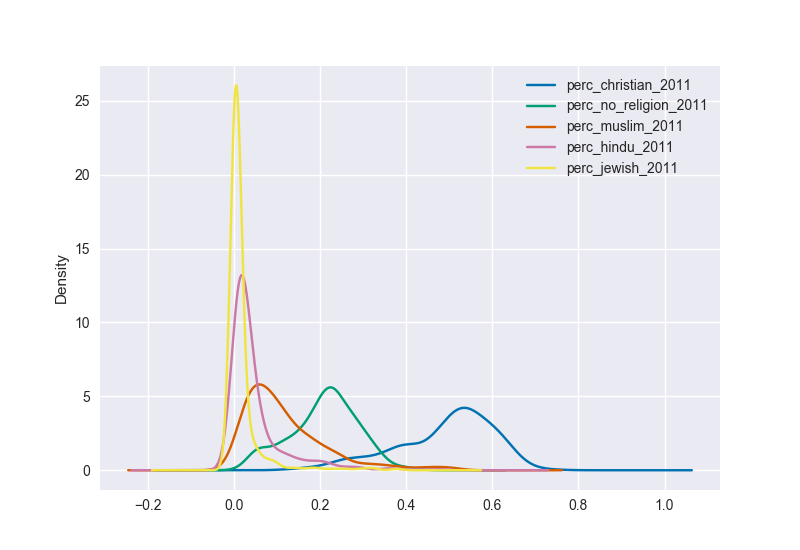

In [296]:
london_wards_percs = ward_profiles[['ward_name','perc_christian_2011','perc_no_religion_2011','perc_muslim_2011','perc_hindu_2011','perc_jewish_2011']][ward_profiles['region_name']=='London']
london_wards_percs.plot.kde()

<IPython.core.display.Javascript object>


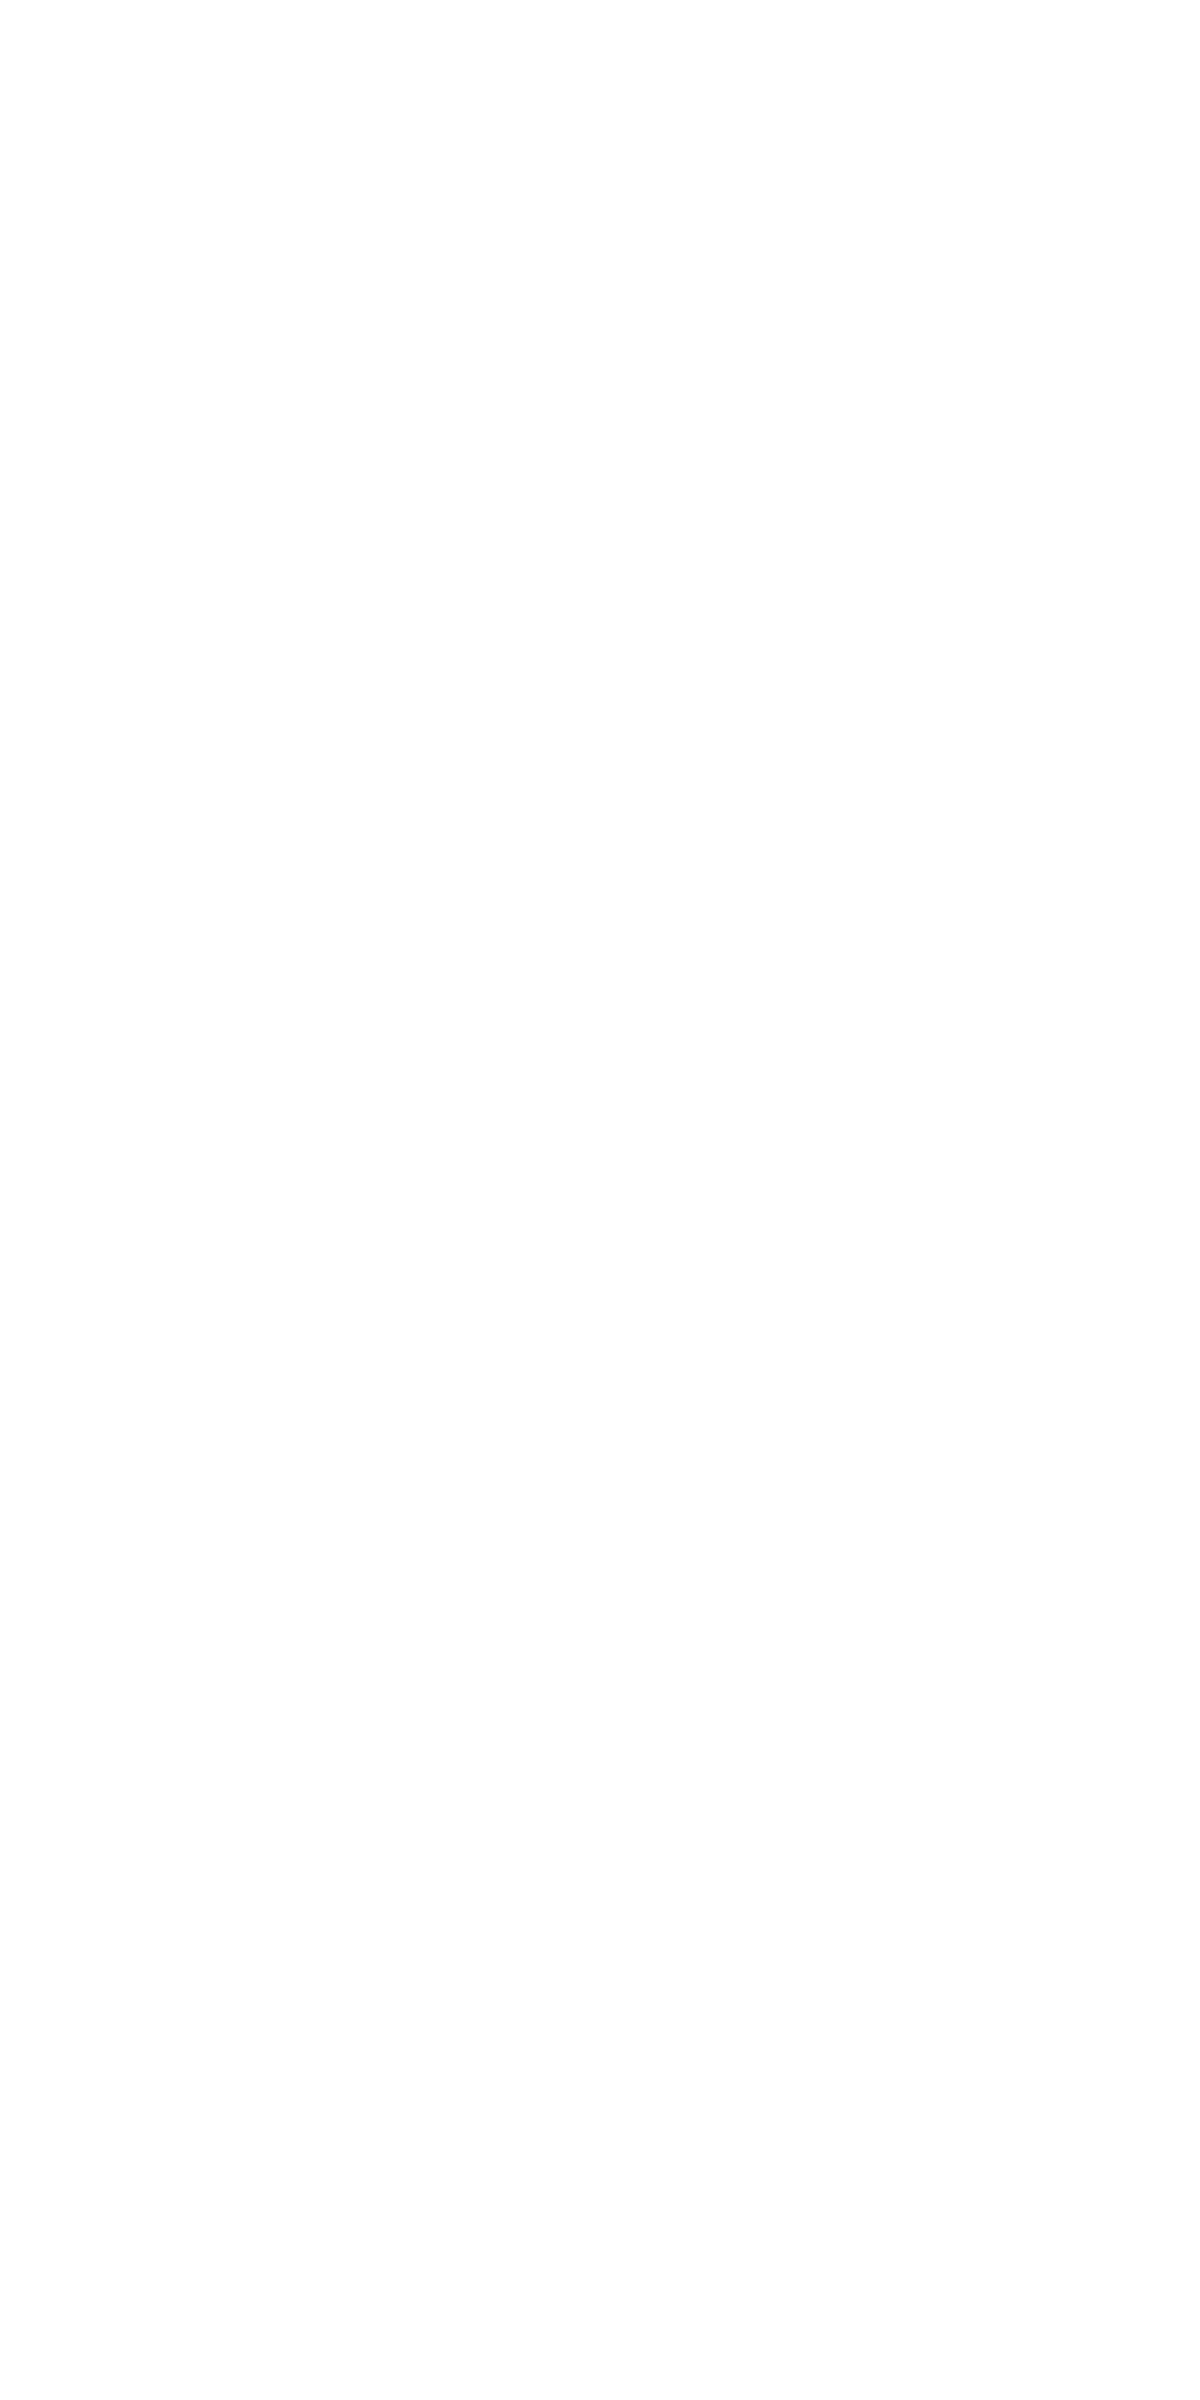

In [386]:
london_wards_change = ward_profiles[['ward_name','pc_pt_change_christian','pc_pt_change_no_religion','pc_pt_change_muslim','pc_pt_change_hindu','pc_pt_change_jewish']][ward_profiles['region_name']=='London']
london_wards_change.plot.kde()

## Create a basemap of London wards to plot changes in religion between censuses

In [ ]:
# Adapted from http://sensitivecities.com/so-youd-like-to-make-a-map-using-python-EN.html#.WOIofXeZOis

In [359]:
shp = fiona.open('data/london/london_wards.shp')
bds = shp.bounds
shp.close()
extra = 0.01
ll = (bds[0], bds[1])
ur = (bds[2], bds[3])
coords = list(chain(ll, ur))
w, h = coords[2] - coords[0], coords[3] - coords[1]

<IPython.core.display.Javascript object>


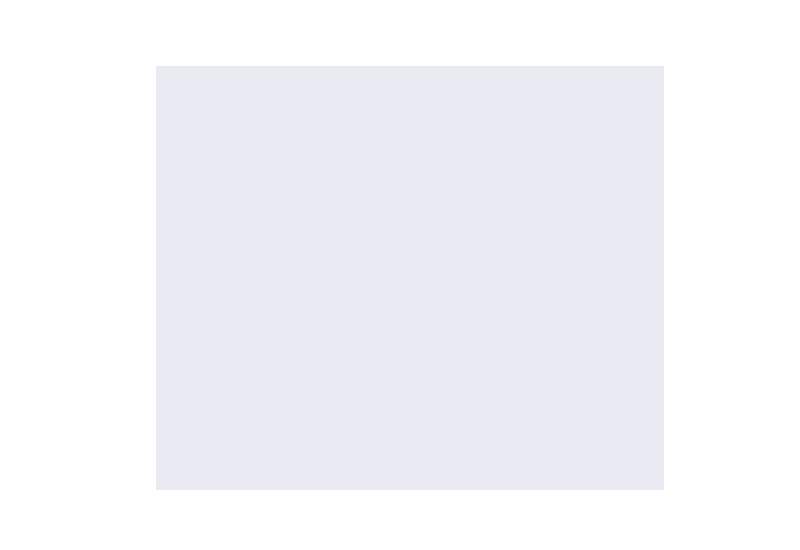

,poly,ward_code
0,"POLYGON ((13004.06946655405 5643.556705337571,...",E05000405
1,"POLYGON ((14432.57909437221 10890.80719853035,...",E05000414
2,"POLYGON ((14710.57509324689 12747.7965992486, ...",E05000401
3,"POLYGON ((17083.95639092114 12354.05967221508,...",E05000400
4,"POLYGON ((18675.541683762 13589.6237209586, 18...",E05000402


In [156]:
m = Basemap(
    projection='tmerc',
    lon_0=-2.,
    lat_0=49.,
    ellps = 'WGS84',
    llcrnrlon=coords[0] - extra * w,
    llcrnrlat=coords[1] - extra + 0.01 * h,
    urcrnrlon=coords[2] + extra * w,
    urcrnrlat=coords[3] + extra + 0.01 * h,
    lat_ts=0,
    resolution='h',
    suppress_ticks=True)
m.readshapefile(
    'data/london/london_wards',
    'london',
    color='none',
    zorder=2)

In [360]:
# set up a map dataframe
ward_map = pd.DataFrame({
    'poly': [Polygon(xy) for xy in m.london],
    'ward_code': [ward['CODE'] for ward in m.london_info]})

ward_map.head()

,poly,ward_code
0,"POLYGON ((13004.06946655405 5643.556705337571,...",E05000405
1,"POLYGON ((14432.57909437221 10890.80719853035,...",E05000414
2,"POLYGON ((14710.57509324689 12747.7965992486, ...",E05000401
3,"POLYGON ((17083.95639092114 12354.05967221508,...",E05000400
4,"POLYGON ((18675.541683762 13589.6237209586, 18...",E05000402


In [361]:
ward_map_profiles = pd.merge(ward_map, ward_profiles, how='inner', on=['ward_code'])
ward_map_profiles.head()

,poly,ward_code,ward_latitude,ward_longitude,country_code,region_code,county_code,local_authority_code,country_name,region_name,...,perc_other_religion_2011,pc_pt_change_christian,pc_pt_change_no_religion,pc_pt_change_muslim,pc_pt_change_religion,pc_pt_change_hindu,pc_pt_change_jewish,pc_pt_change_sikh,pc_pt_change_buddhist,pc_pt_change_other_religion
0,"POLYGON ((13004.06946655405 5643.556705337571,...",E05000405,517652.314477,162339.127460,E92000001,E12000007,E13000002,E09000021,England,London,...,0.004789,-0.141481,0.105942,0.010841,0.007364,0.009489,0.001029,0.002695,0.001231,0.002891
1,"POLYGON ((14432.57909437221 10890.80719853035,...",E05000414,519124.606878,165299.864453,E92000001,E12000007,E13000002,E09000021,England,London,...,0.005085,-0.131125,0.073413,0.021419,0.003028,0.024959,0.000336,0.001328,0.003555,0.003086
2,"POLYGON ((14710.57509324689 12747.7965992486, ...",E05000401,519108.607104,167343.660523,E92000001,E12000007,E13000002,E09000021,England,London,...,0.006252,-0.126092,0.095991,0.016632,0.009445,0.005061,-0.002473,-0.000874,0.002856,-0.000545
3,"POLYGON ((17083.95639092114 12354.05967221508,...",E05000400,520116.517627,166392.332020,E92000001,E12000007,E13000002,E09000021,England,London,...,0.003136,-0.125773,0.050252,0.023409,0.008310,0.039016,-0.000982,0.006702,-0.000419,-0.000514
4,"POLYGON ((18675.541683762 13589.6237209586, 18...",E05000402,521204.080067,168516.622160,E92000001,E12000007,E13000002,E09000021,England,London,...,0.005540,-0.076568,0.045630,0.015346,-0.006976,0.014506,0.000219,0.002363,0.002996,0.002485


In [448]:
print(ward_map_profiles['ward_latitude'].min())

505214.806696


In [486]:
min_christian = ward_map_profiles[ward_map_profiles['pc_pt_change_christian'] == ward_map_profiles['pc_pt_change_christian'].min()]
print(min_christian[['local_authority_name', 'ward_name', 'ward_latitude', 'ward_longitude', 'perc_christian_2001','perc_christian_2011', 'pc_pt_change_christian']])

     local_authority_name   ward_name  ward_latitude  ward_longitude  \
612  Barking and Dagenham  Longbridge  545482.495915   184854.209395   

     perc_christian_2001  perc_christian_2011  pc_pt_change_christian  
612             0.735681              0.42185               -0.313831  


In [488]:
max_christian = ward_map_profiles[ward_map_profiles['pc_pt_change_christian'] == ward_map_profiles['pc_pt_change_christian'].max()]
print(max_christian[['local_authority_name', 'ward_name', 'ward_latitude', 'ward_longitude', 'perc_christian_2001','perc_christian_2011', 'pc_pt_change_christian']])

    local_authority_name ward_name  ward_latitude  ward_longitude  \
589               Newham   Beckton  543892.963581   181657.533177   

     perc_christian_2001  perc_christian_2011  pc_pt_change_christian  
589             0.518233             0.542129                0.023896  


In [487]:
max_muslim = ward_map_profiles[ward_map_profiles['pc_pt_change_muslim'] == ward_map_profiles['pc_pt_change_muslim'].max()]
print(max_muslim[['local_authority_name', 'ward_name', 'ward_latitude', 'ward_longitude', 'perc_muslim_2001', 'perc_muslim_2011', 'pc_pt_change_muslim']])

     local_authority_name   ward_name  ward_latitude  ward_longitude  \
612  Barking and Dagenham  Longbridge  545482.495915   184854.209395   

     perc_muslim_2001  perc_muslim_2011  pc_pt_change_muslim  
612          0.046585          0.320178             0.273593  


In [489]:
max_jewish = ward_map_profiles[ward_map_profiles['pc_pt_change_jewish'] == ward_map_profiles['pc_pt_change_jewish'].max()]
print(max_jewish[['local_authority_name', 'ward_name', 'ward_latitude', 'ward_longitude', 'perc_jewish_2001','perc_jewish_2011', 'pc_pt_change_jewish']])

    local_authority_name ward_name  ward_latitude  ward_longitude  \
559              Hackney  Cazenove  534087.403591   187007.554771   

     perc_jewish_2001  perc_jewish_2011  pc_pt_change_jewish  
559           0.13435          0.221212             0.086862  


In [447]:
# Create Point objects in map coordinates from dataframe lon and lat values
map_points = pd.Series(
    [Point(m(mapped_x, mapped_y)) for mapped_x, mapped_y in zip(ward_map_profiles['ward_longitude'], ward_map_profiles['ward_latitude'])])
wards_points = MultiPoint(list(map_points.values))
wards_polygon = prep(MultiPolygon(list(ward_map_profiles['poly'].values)))
# calculate points that fall within the London boundary
ldn_points = filter(wards_polygon.contains, wards_points)

## Create a choropleth map

<IPython.core.display.Javascript object>


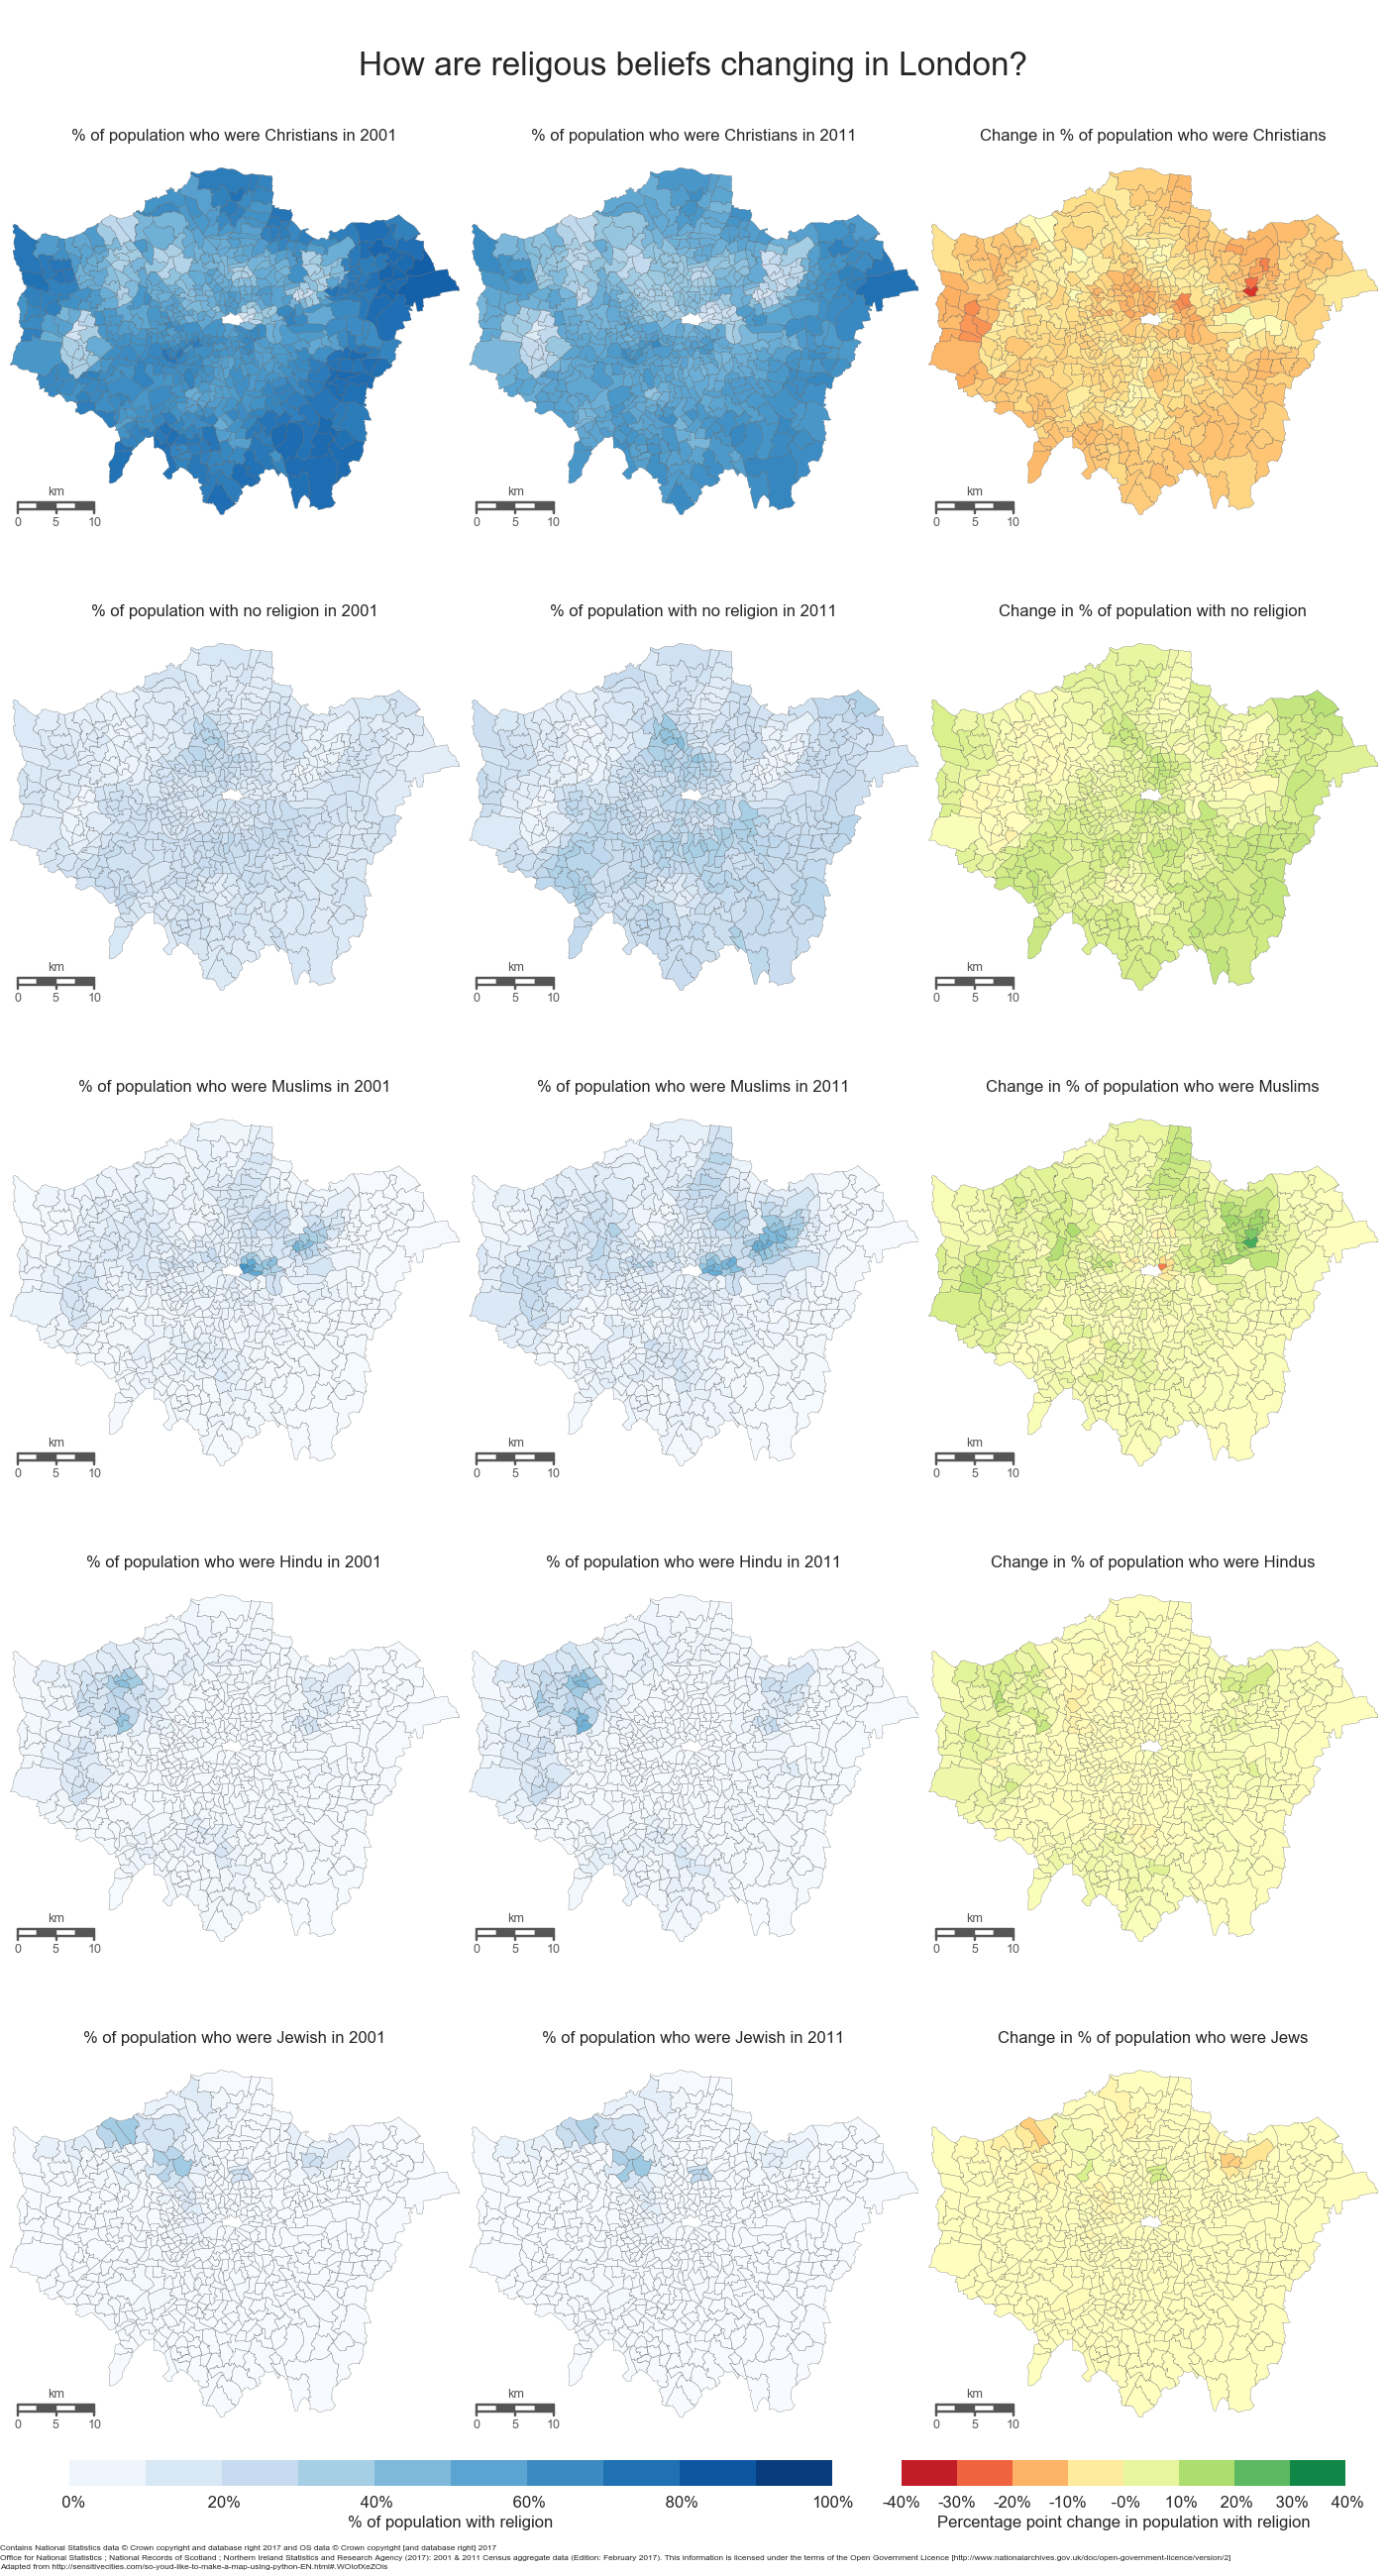

/Users/nigelnicholson/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/nigelnicholson/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


In [482]:
plt.clf()
fig = plt.figure(figsize=(14, 26))

def add_subplot(var_name, position, cmp, ttl, norm):

    ax = fig.add_subplot(5,3,position, facecolor='w', frame_on=False)
    
    cmap = plt.get_cmap(cmp)
    # draw wards with grey outlines
    ward_map_profiles['patches'] = ward_map_profiles['poly'].map(lambda x: PolygonPatch(x, ec='#555555', lw=.2, alpha=1., zorder=4))
    pc = PatchCollection(ward_map_profiles['patches'], match_original=True)
    # impose our colour map onto the patch collection
    if norm == 'Y':
        norm = Normalize(vmin=-0.4, vmax=0.4)
        pc.set_facecolor(cmap(norm(ward_map_profiles[var_name].values)))

    else:
        pc.set_facecolor(cmap(ward_map_profiles[var_name].values))
    
    ax.add_collection(pc)
    ax.set_title(ttl)
    
    # Draw a map scale
    m.drawmapscale(
        coords[0] + 0.08, coords[1] + 0.015,
        coords[0], coords[1],
        10.,
        barstyle='fancy', labelstyle='simple',
        fillcolor1='w', fillcolor2='#555555',
        fontcolor='#555555',
        zorder=5) 
    
    plt.tight_layout()
    plt.suptitle('How are religous beliefs changing in London?', fontsize=24)

    plt.show()
    
add_subplot('perc_christian_2001',1,'Blues','% of population who were Christians in 2001','N')
add_subplot('perc_christian_2011',2,'Blues','% of population who were Christians in 2011','N')
add_subplot('pc_pt_change_christian',3,'RdYlGn','Change in % of population who were Christians','Y')
add_subplot('perc_no_religion_2001',4,'Blues','% of population with no religion in 2001','N')
add_subplot('perc_no_religion_2011',5,'Blues','% of population with no religion in 2011','N')
add_subplot('pc_pt_change_no_religion',6,'RdYlGn','Change in % of population with no religion','Y')
add_subplot('perc_muslim_2001',7,'Blues','% of population who were Muslims in 2001','N')
add_subplot('perc_muslim_2011',8,'Blues','% of population who were Muslims in 2011','N')
add_subplot('pc_pt_change_muslim',9,'RdYlGn','Change in % of population who were Muslims','Y')
add_subplot('perc_hindu_2001',10,'Blues','% of population who were Hindu in 2001','N')
add_subplot('perc_hindu_2011',11,'Blues','% of population who were Hindu in 2011','N')
add_subplot('pc_pt_change_hindu',12,'RdYlGn','Change in % of population who were Hindus','Y')
add_subplot('perc_jewish_2001',13,'Blues','% of population who were Jewish in 2001','N')
add_subplot('perc_jewish_2011',14,'Blues','% of population who were Jewish in 2011','N')
add_subplot('pc_pt_change_jewish',15,'RdYlGn','Change in % of population who were Jews','Y')

'''
text(0.5, 0.5,'matplotlib',
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax.transAxes)
'''

tax1 = fig.add_axes([0.0, 0.0, 0.95, 0.0125], facecolor='w', frameon=False, alpha=0)

tax1.text(0,0.8,"Contains National Statistics data © Crown copyright and database right 2017 and OS data © Crown copyright [and database right] 2017")
tax1.text(0,0.5,"Office for National Statistics ; National Records of Scotland ; Northern Ireland Statistics and Research Agency (2017): 2001 & 2011 Census aggregate data (Edition: February 2017). This information is licensed under the terms of the Open Government Licence [http://www.nationalarchives.gov.uk/doc/open-government-licence/version/2]")
tax1.text(0,0.2,"Adapted from http://sensitivecities.com/so-youd-like-to-make-a-map-using-python-EN.html#.WOIofXeZOis")
tax1.yaxis.set_visible(False)

cax1 = fig.add_axes([0.05, 0.035, 0.55, 0.01])
cmap1 = cm.Blues
norm1 = Normalize(vmin=0, vmax=1)
bounds1 = np.arange(0.0,1.1,0.1)
cb1 = clb.ColorbarBase(cax1, cmap=cmap1, norm=norm1, orientation='horizontal',boundaries=bounds1)
cb1.ax.tick_params(labelsize=12)
cb1_vals = cb1.ax.get_xticks()
cb1.ax.set_xticklabels(['{:3.0f}%'.format(x*100) for x in cb1_vals])
cb1.set_label('% of population with religion', fontsize=12)

cax2 = fig.add_axes([0.65, 0.035, 0.32, 0.01])
cmap2 = cm.RdYlGn
norm2 = Normalize(vmin=-0.4, vmax=0.4)
bounds2 = np.arange(-0.4,0.5,0.1)
cb2 = clb.ColorbarBase(cax2, cmap=cmap2, norm=norm2, orientation='horizontal',boundaries=bounds2)
cb2.ax.tick_params(labelsize=12)
#cb2_vals = cb2.ax.get_xticks()
cb2.ax.set_xticklabels(['{:3.0f}%'.format(x*100) for x in bounds2])
cb2.set_label('Percentage point change in population with religion', fontsize=12)

fig.savefig('how_have_religous_beliefs_changed_in_london.jpg', bbox_inches='tight')